## Imports

In [76]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.constants as c
import scipy as sc
phc = c.physical_constants
import sys
sys.path.append('/home/excalibur/pCloudDrive/Informatik/Python/')
from self_written_functions import *
from scipy.interpolate import interp1d
sys.path.append('/home/excalibur/Dropbox/Bachelor')
from main_class import *

In [82]:
plt.style.use('~/pCloudDrive/Informatik/Python/matplotlibrc/notebook')

# Introduction, Goal

Es wurde eine Messung mit 360nm (FWHM=10nm) Filter nach der Lampe, ohne WLS auf dem Dia sowie ohne Filter vor der Diode aufgenommen. Das Ziel ist es, aus diesen Daten die Rate der einfallenden Photonen zu bestimmen, also derer die auf das Dia treffen.

# Math

Für den Aufbau ergibt sich folgende Formel:

$$I_{PD}(\theta) = \int I_{lamp}(\lambda) \cdot \varepsilon_{360}(\lambda) \cdot \varepsilon_{Blende} \cdot d\lambda \cdot \int  S_{360}(\lambda) \cdot R_{PD}(\lambda) \cdot d\lambda \cdot \varepsilon_{Geo}(\theta) \cdot \Delta \Omega$$

* $I_{lamp}(\lambda)$: von der Lampe erzeugte "Intensität" (richtige Einheiten?)
* $\varepsilon_{360}$: Transmission des 360nm-Filters
* $S_{360}$: Spektrum des 360nm-Filters, also Transmission auf 1 normiert
* $\varepsilon_{Geo}(\theta)$: geometrischer Korrekturfaktor, gibt an welcher Anteil der Intensität unter welchem Raumwinkel zu finden ist (unbekannt), auch bei dieser Messung vorhanden, da Strahl ausgedehnt ist
* $\Delta\Omega$: von der Photodiode abgedeckter Raumwinkel
* $R_{PD}(\lambda)$: Response-Function der Photodiode, Einheiten $\frac{A}{W}$


Das erste Integral entspricht somit der "Intensität", die das Dia trifft. An dieser sind wir interessiert, da wir über sie und die Energie der Photonen die Rate der Photonen berechnen können. Die einzelnen Faktoren des Integrals benötigen wir nicht und setzen daher: $$I_{Dia} := \int I_{lamp}(\lambda) \cdot \varepsilon_{360}(\lambda) \cdot \varepsilon_{Blende} \cdot d\lambda$$

Das zweite Integral entspricht der über das Filterspektrum gemittelten Response-Funktion der Photodiode. Dies können wir berechnen und schreiben: $$R_{PD,360} := \int  S_{360}(\lambda) \cdot R_{PD}(\lambda) \cdot d\lambda$$

Somit folgt

$$I_{PD}(\theta) = I_{Dia} \cdot R_{PD,360} \cdot \varepsilon_{Geo}(\theta) \cdot \Delta \Omega$$
$$\Leftrightarrow$$
$$\frac{I_{PD}(\theta)}{\Delta \Omega} = I_{Dia} \cdot R_{PD,360} \cdot \varepsilon_{Geo}(\theta)$$

Da wir $\varepsilon_{Geo}(\theta)$ nicht genau kennen und unsere gesamte Messung verwenden wollen und nicht nur eine Position, integrieren wir über unsere Messung.

$$I_{total,PD} = \int_0^{\frac{\pi}{2}} \frac{I_{PD}(\theta)}{\Delta\Omega} \cdot \sin(\theta) \cdot d\theta \int_0^{2 \pi} d\varphi = I_{Dia} \cdot R_{PD,360} \cdot \int_0^{\frac{\pi}{2}} \int_0^{2 \pi} \varepsilon_{Geo}(\theta) \cdot \sin(\theta) \cdot d\theta \cdot d\varphi$$

Das Integral über $\varepsilon_{Geo}(\theta)$ kennen wir, es ist der Anteil des Lichts, der das Dia verlässt (also nicht totalreflektiert wird). Bei dieser Messung sind dies 100% (da es keine Reemission gibt).
Wir definieren ihn als $\varepsilon_{\Omega}$.

Somit ergibt sich:

$$I_{total,PD} = I_{Dia} \cdot R_{PD,360} \cdot \varepsilon_{\Omega}$$
$$\Leftrightarrow$$
$$I_{Dia} =  \frac{I_{total,PD}}{R_{PD,360} \cdot \varepsilon_{\Omega}}$$

Um auf die Rate der Photonen zu kommen, berechnen wir:

$$ R_{\gamma} = \frac{I_{Dia}}{E_{\gamma,360}} = \frac{I_{total,PD}}{R_{PD,360} \cdot E_{\gamma,360} \cdot \varepsilon_{\Omega}}$$

Wobei $E_{\gamma,360}$ wiederum die mit dem Spektrum des 360nm-Filters gewichtete Energie der Photonen ist, also die mittlere Photonenenergie.

# Calculation

## Importing Data and Interpolations

In [3]:
os.chdir("/home/excalibur/Dropbox/Bachelor/")

#### Interpolation of measured current

In [112]:
### insert run_in number ###
### proper time synchronization? ###
runXX = EngAndDemData('132')
runXX.synchronizing_time()
runXX.get_final_data()

Synchronized time with a time-difference of 2.0585564673251504.


In [113]:
### add +/- ? so the peak is symmetric ###
current_data = np.array([runXX.eng_means[0], runXX.dem_means[0]]).T

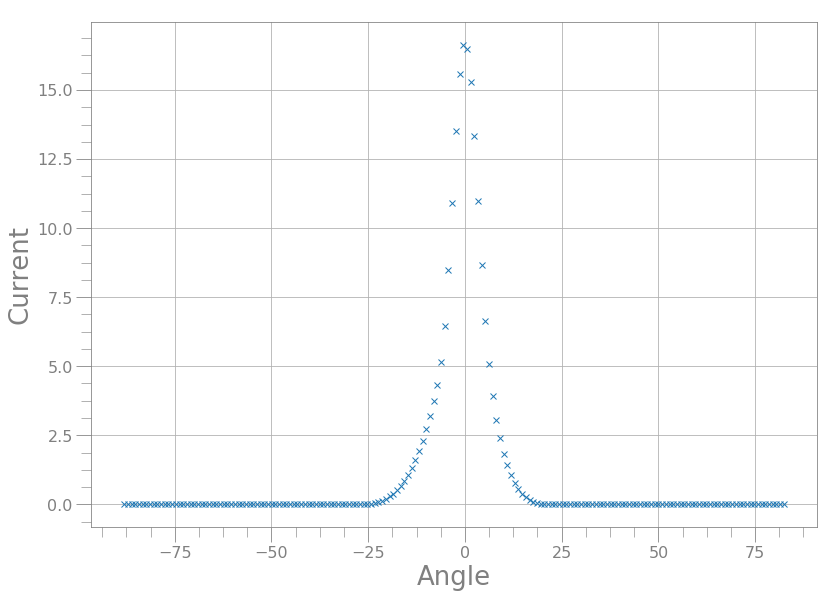

In [114]:
fig = plt.figure()
plt.plot(current_data.T[0], current_data.T[1], 'x') 
plt.xlabel(r"Angle")
plt.ylabel(r"Current");

In [115]:
current_inter = interp1d(current_data.T[0], current_data.T[1], kind='cubic')

Der Durchschnitt über beide Seiten wird genommen. In der Theorie sollte die Verteilung symmetrisch sein.

In [116]:
def current_inter_average(theta):
    """
        theta [degree]
        returns [nA]
    """
    return (current_inter(theta) + current_inter(-theta)) / 2

In [117]:
### adjust borders ###
borders = (0, np.deg2rad(75))

#### Interpolation of response function

In [118]:
response_data = np.genfromtxt('spectren/SM1PD2A_sensitivity.txt')
response_inter = interp1d(response_data.T[0], response_data.T[1] * 10**9, kind='cubic')  # from A/W to nA/W

#### Interpolation of 360nm-Filter

In [119]:
filter_360_data = np.genfromtxt('spectren/FB360-10.csv')
# muss aufsteigend sein für Interpolation, daher [::-1]
filter_360_inter = sc.interpolate.UnivariateSpline(filter_360_data.T[0][::-1], 
                                                   filter_360_data.T[1][::-1] * 10**-2)  # from % to 0.xx

Wir benötigen später das normalisierte Spektrum vom Filter $S_{360}(\lambda)$. Zum Normalisieren benutzen wir den Bereich von 300nm bis 400nm, da nur dieser für uns relevant ist (UV-Lampe erzeugt kein Licht bei 200nm).

In [120]:
filter_360_borders = (300, 400)  # nm
norm = filter_360_inter.integral(filter_360_borders[0], filter_360_borders[1])
def filter_360_normalized(lambda_):
    return filter_360_inter(lambda_) / norm

## Integrating Current

Im folgenden berechnen wir: $$I_{total,PD} = \int_0^{\frac{\pi}{2}} \frac{I_{PD}(\theta)}{\Delta\Omega} \cdot \sin(\theta) \cdot d\theta \int_0^{2 \pi} d\varphi$$

Die Grenzen des ersten Integrals werden entsprechend unserer Messung angepasst, da wir für Winkel nahe 90° keine Messwerte besitzen, die Stromstärke dort jedoch sowieso 0nA ist.

Der genaue numerische Wert des vom Detektor abgedeckten Raumwinkels ist egal, da wir später nur relative Werte berechnen wollen und er sich somit rauskürzt. Wir müssen ihn nur über alle Rechnungen konstant halten.

In [121]:
detector_distance = 6.0  # distance to detector [cm]
detector_window = 0.5  # diameter of detector window [cm]
detector_radius = detector_window / 2
detector_solid_angle = np.pi * detector_radius**2 / detector_distance**2

In [122]:
def integrand(theta):
    """
        theta [rad]
        returns: I_d_omega [nA / sr]
    """
    return current_inter_average(np.rad2deg(theta)) / detector_solid_angle * np.sin(theta) 

I_total_pd = sc.integrate.quad(integrand, borders[0], borders[1], limit=1500)[0] * 2 * np.pi  # nA
I_total_pd

139.00469196730026

## Current to n_photons

Nun berechnen wir die Rate der Photonen:
$$ R_{\gamma} = \frac{I_{Dia}}{E_{\gamma,360}} = \frac{I_{total,PD}}{R_{PD,360} \cdot E_{\gamma,360} \cdot \varepsilon_{\Omega}}$$

$\varepsilon_{\Omega}$ ist wie oben erwähnt gleich 1.

In [123]:
def integrand_R_pd(lambda_):
    return response_inter(lambda_) * filter_360_normalized(lambda_)

R_pd_360 = sc.integrate.quad(integrand_R_pd, filter_360_borders[0], filter_360_borders[1])[0]

In [124]:
# check:
print(response_inter(360))
print(R_pd_360)

152890000.0
157916701.09587556


In [125]:
def integrand_E_gamma(lambda_):
    E_gamma = phc['Planck constant'][0] * phc['speed of light in vacuum'][0] / (lambda_ * 10**-9)  # J
    return E_gamma * filter_360_normalized(lambda_)

E_gamma_360 = sc.integrate.quad(integrand_E_gamma, filter_360_borders[0], filter_360_borders[1])[0]

In [126]:
R_gamma = I_total_pd / (E_gamma_360 * R_pd_360)  # n_photons / s
eprint(R_gamma)

1.530128e+12


In [78]:
#  87: 6.735928e+11
# 118: 2.792913e+12
# 120: 2.032116e+12
# 128: 2.052324e+12
# 129: 1.912311e+12, 161.3 nA (should be same as 132)
# 129: 1.706974e+12 (with using 360nm-filter spectrum)
# 132: 1.871684e+12, 157.9 nA
# 132: 1.530128e+12 (with using 360nm-filter spectrum)